In [1]:
import sys
import numpy as np
from PyQt5.QtWidgets import QApplication, QMainWindow, QGraphicsScene, QGraphicsView, QGraphicsEllipseItem, QToolBar, QAction, QGraphicsLineItem
from PyQt5.QtGui import QBrush, QColor, QPen
from PyQt5.QtCore import QTimer, QPointF, Qt
from scipy.interpolate import interp1d
import pickle


In [2]:

class ParticleVisualizer(QMainWindow):
    def __init__(self, particle_trajectories, segments, borders, interp_steps):
        super().__init__()
        self.num_particles = len(particle_trajectories)
        self.borders = borders
        self.num_steps = len(particle_trajectories[0])
        self.segments = segments
        self.interp_steps = interp_steps
        self.current_step = 0
        self.particle_trajectories = particle_trajectories
        self.interpolated_trajectories = self.interpolate_trajectories()
        self.initUI()
        self.startAnimation()

    def initUI(self):
        # [Unchanged code: Set up window, scene, view, toolbar]
        # Set up the main window and widgets
        self.setGeometry(100, 100, 700, 550)
        self.setWindowTitle('Particle Visualization')

        

        # Graphics Scene and View
        self.scene = QGraphicsScene()

        self.scene.setSceneRect(0, 0, 700, 550)
        self.view = QGraphicsView(self.scene, self)
        self.view.setGeometry(20, 20, 760, 560)



        # Toolbar and buttons
        self.toolbar = QToolBar("Control Toolbar")
        self.addToolBar(self.toolbar)

        self.nextAction = QAction('Next', self)
        self.nextAction.triggered.connect(self.nextStep)
        self.toolbar.addAction(self.nextAction)

        # Initialize particles as small black dots
        self.particles = [QGraphicsEllipseItem(0, 0, 1, 1) for _ in range(self.num_particles)]
        for particle in self.particles:
            particle.setBrush(QBrush(QColor(0, 0, 0)))  # Set particle color to black
            self.scene.addItem(particle)

        self.border_segments = [QGraphicsLineItem(seg[0], seg[1], seg[2], seg[3]) for seg in self.borders]
        for segment in self.border_segments:
            segment.setPen(QPen(Qt.blue, 1))
            self.scene.addItem(segment)

        self.segments = [QGraphicsLineItem(seg[0], seg[1], seg[2], seg[3]) for seg in self.segments]
        for segment in self.segments:
            segment.setPen(QPen(Qt.black, 2))
            self.scene.addItem(segment)

        # Set initial particle positions
        self.updateParticles(self.current_step)

    def interpolate_trajectories(self):
        interpolated = []
        for trajectory in self.particle_trajectories:
            x, y = zip(*trajectory)
            time = np.linspace(0, 1, self.num_steps)
            interp_time = np.linspace(0, 1, self.interp_steps)
            interp_x = interp1d(time, x, kind='cubic')(interp_time)
            interp_y = interp1d(time, y, kind='cubic')(interp_time)
            interpolated.append(list(zip(interp_x, interp_y)))
        return interpolated

    def updateParticles(self, step):
        for particle, trajectory in zip(self.particles, self.interpolated_trajectories):
            particle.setPos(QPointF(trajectory[step][0], trajectory[step][1]))

    def startAnimation(self):
        self.timer = QTimer()
        self.timer.timeout.connect(self.nextStep)
        self.timer.start(20)  # Adjust the timing for smoother or faster animation

    def nextStep(self):
        self.current_step = (self.current_step + 1) % self.interp_steps
        self.updateParticles(self.current_step)

In [3]:
def load_hist(filename):
    with open(filename, 'rb') as f:
        hist = pickle.load(f)
    with open('Pressure.pkl', 'rb') as f:
        pressure = pickle.load(f)

    return hist, pressure

def load_config():
    with open('Config.pkl', 'rb') as f:
        config = pickle.load(f)
    return config

def gen_bounding_segments(config):
    top = [config['xmin'], config['ymin'], config['xmax'], config['ymin']]
    bottom = [config['xmin'], config['ymax'], config['xmax'], config['ymax']]
    left = [config['xmin'], config['ymin'], config['xmin'], config['ymax']]
    right = [config['xmax'], config['ymin'], config['xmax'], config['ymax']]

    return [top, bottom, left, right]

In [4]:
hist, pressure = load_hist('Hist1.pkl')
conf = load_config()
borders = gen_bounding_segments(conf)

In [5]:

# Main
probe_trajectory = hist
segments = conf['segments']


app = QApplication(sys.argv)
ex = ParticleVisualizer(probe_trajectory, segments, borders, 50)
ex.show()
app.exec_()

0

In [6]:
from matplotlib import pyplot as plt
from scipy.ndimage import convolve

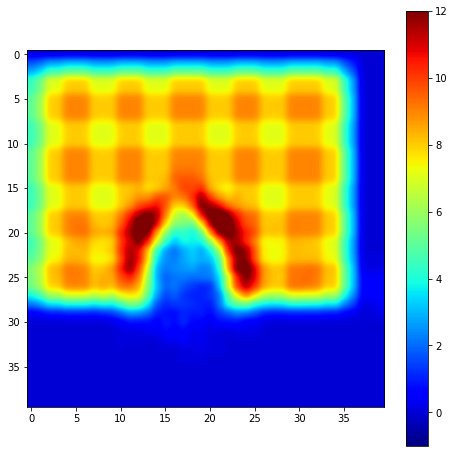

In [25]:
N = 130
press_frame = pressure[N].copy()
#press_frame[press_frame == 0] = np.mean(press_frame)

kernel_n = 3
avg_kernel= np.ones((kernel_n, kernel_n))/(kernel_n**2)

press_frame = convolve(press_frame, avg_kernel)

plt.figure(figsize = (8,8))
plt.imshow(press_frame.transpose(), interpolation = 'gaussian', vmin = -1, vmax = 12, cmap = 'jet')
plt.colorbar()
plt.show()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter, FuncAnimation

# Suppose 'arrays' is your list of 2D numpy arrays
arrays = pressure[::3]

# Create a figure and an axes
fig, ax = plt.subplots(figsize = (7,7))

# Function to update each frame in the animation
def update(frame):
    frame = convolve(frame, avg_kernel)
    ax.set_title('Pressure field')
    ax.imshow(frame.transpose(), interpolation = 'gaussian', vmin = -1, vmax = 15, cmap = 'jet')  # or any colormap you prefer
    return [ax]

# Create animation using the update function
ani = FuncAnimation(fig, update, frames=arrays, blit=False)

# Save the animation
ani.save('my_animation.gif', writer=PillowWriter(fps=20))  # Set your desired fps

plt.close()
